<a href="https://colab.research.google.com/github/stiwari-ds/DL-Simplified-SWOC-S3/blob/dance-form-clf/Dance-Form-Classification/Model/03_transfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import gc
import warnings
import subprocess

gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
SEED = 2311
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#Check GPU availability
try:
    subprocess.check_output('nvidia-smi')
    HAVE_GPU = True
except Exception:
    HAVE_GPU = False

print(f'GPU available: {HAVE_GPU}')

GPU available: True


# Data

In [ ]:
%%capture
if not os.path.isdir('/content/train'):
    # runs fine despite syntax warning
    !wget https://storage.googleapis.com/dance-forms-dataset/dance_forms.zip
    !unzip dance_forms.zip

In [ ]:
PROCESSED_DATA_URL = "https://raw.githubusercontent.com/stiwari-ds/DL-Simplified-SWOC-S3/dance-form-clf/Dance-Form-Classification/Dataset/processed"
#From notebook 01
train_df = pd.read_csv(f'{PROCESSED_DATA_URL}/train_df.csv', dtype='string') # filename->label mapping
test_df = pd.read_csv(f'{PROCESSED_DATA_URL}/test_df.csv', dtype='string')

image_dir = '/content/train/' # images directory

# Modeling

**Data pipeline**:

In [ ]:
CLASSES = list(train_df.target.unique())
X_COL = train_df.columns[0]
Y_COL = train_df.columns[-1]
CLASS_MODE = 'categorical'

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = TARGET_SIZE + (3, ) #3 channels for RGB

In [ ]:
def build_data_pipeline(image_dir, train_df, test_df, augment_args=None):
    if augment_args:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, **augment_args)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    test_datagen = ImageDataGenerator(rescale=1./255) # unaffected by data augmentation

    #training data
    train_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='training',
        shuffle=True,
        seed=SEED
    )
    #validation data
    val_batches = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=X_COL,
        y_col=Y_COL,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        classes=CLASSES,
        subset='validation',
        shuffle=True,
        seed=SEED
    )
    #test data
    test_batches = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=X_COL,
        target_size=TARGET_SIZE,
        batch_size=1,   # prediction done one sample at a time
        class_mode=None,    # no class associated with test sample
        shuffle=False
    )
    return train_batches, val_batches, test_batches

In [ ]:
augment_args = {
    'rotation_range': 20, #degrees
    'shear_range': 0.1,
    'zoom_range': 0.2,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': True
}

train_batches, val_batches, test_batches = build_data_pipeline(
    image_dir, train_df, test_df, augment_args
)

Found 240 validated image filenames belonging to 8 classes.
Found 60 validated image filenames belonging to 8 classes.
Found 64 validated image filenames.


**Model fitting & evaluation framework**:

In [ ]:
def plot_training_curve(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].plot(epochs, train_loss, label='train_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].minorticks_on()
    ax[0].legend()
    ax[1].plot(epochs, train_accuracy, label='train_accuracy')
    ax[1].plot(epochs, val_accuracy, label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].minorticks_on()
    ax[1].legend()
    plt.show()

In [ ]:
def fit_model(model, train_batches, val_batches, epochs=10):
    verbose = 2 if epochs <= 10 else 0
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=2e-4,
        patience=20,
        verbose=0,
        mode='max',
        restore_best_weights=True
    )
    history = model.fit(
        x=train_batches,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=verbose,
        steps_per_epoch=len(train_batches),
        validation_data=val_batches,
        validation_steps=len(val_batches)
    )
    print(f"Stopped training after {len(history.history['loss'])} epochs\n")
    plot_training_curve(history)

    return model, history

In [ ]:
def evaluate_model(model, val_batches, test_batches):
    val_score = model.evaluate(val_batches, verbose=0)
    print(f'---VALIDATION---\nloss = {val_score[0]:.4f}, accuracy = {val_score[1]*100:.2f}%')

    test_proba = model.predict(test_batches, verbose=0)
    test_preds = test_proba.argmax(axis=-1)
    test_preds_classes = [CLASSES[pred] for pred in test_preds]

    print('\n---TEST---')
    cm = ConfusionMatrixDisplay.from_predictions(test_df.target, test_preds_classes, cmap='Blues')
    cm.ax_.set_title('Confusion Matrix', fontsize=15, ha='center')
    cm.figure_.set_figheight(10)
    cm.figure_.set_figwidth(10)
    plt.xticks(rotation=30)
    plt.show()

    print('\nClassification Report:')
    print(classification_report(test_df.target, test_preds_classes))

**Building model architecture**:

In [ ]:
base_model = applications.densenet.DenseNet201(
    weights='imagenet', input_shape=INPUT_SHAPE, include_top=False
)

base_model.trainable = False # not trainable for stage-1

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(8, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                        

## Stage-1: Training feature extraction model to convergence (same as notebook 02)

Stopped training after 43 epochs



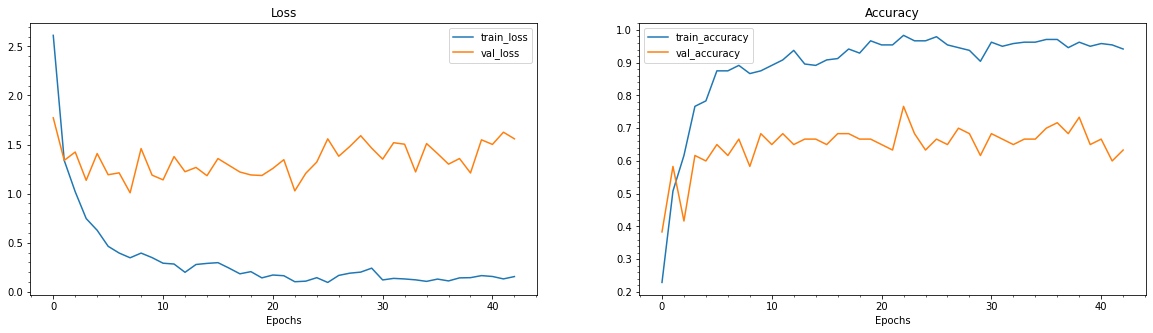

In [ ]:
model, history = fit_model(model, train_batches, val_batches, epochs=100)

---VALIDATION---
loss = 1.3983, accuracy = 61.67%

---TEST---


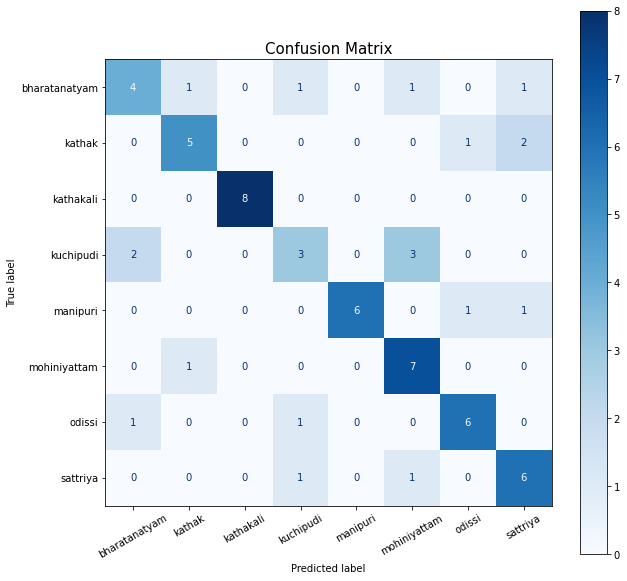


Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.57      0.50      0.53         8
       kathak       0.71      0.62      0.67         8
    kathakali       1.00      1.00      1.00         8
    kuchipudi       0.50      0.38      0.43         8
     manipuri       1.00      0.75      0.86         8
 mohiniyattam       0.58      0.88      0.70         8
       odissi       0.75      0.75      0.75         8
     sattriya       0.60      0.75      0.67         8

     accuracy                           0.70        64
    macro avg       0.71      0.70      0.70        64
 weighted avg       0.71      0.70      0.70        64



In [ ]:
evaluate_model(model, val_batches, test_batches)

## Stage-2: Fine-tuning top few layers of pretrained base model

In [ ]:
model.layers

In [ ]:
layer_names = [layer.name for layer in base_model.layers]

In [ ]:
layer_names[-20:]

['conv5_block30_1_bn',
 'conv5_block30_1_relu',
 'conv5_block30_2_conv',
 'conv5_block30_concat',
 'conv5_block31_0_bn',
 'conv5_block31_0_relu',
 'conv5_block31_1_conv',
 'conv5_block31_1_bn',
 'conv5_block31_1_relu',
 'conv5_block31_2_conv',
 'conv5_block31_concat',
 'conv5_block32_0_bn',
 'conv5_block32_0_relu',
 'conv5_block32_1_conv',
 'conv5_block32_1_bn',
 'conv5_block32_1_relu',
 'conv5_block32_2_conv',
 'conv5_block32_concat',
 'bn',
 'relu']

For Stage-2, the first part of fine-tuning, we will unfreeze the last 2 blocks.  
First the whole base model will be made trainable and then the layers will be frozen manually according to need.

In [ ]:
layer_names[:-16][-1] #last layer to be frozen

'conv5_block30_concat'

In [ ]:
model.layers[0].trainable = True

In [ ]:
for layer in model.layers[0].layers[:-16]:
    layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                        

Model needs to be recompiled after altering the layers:

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

Stopped training after 43 epochs



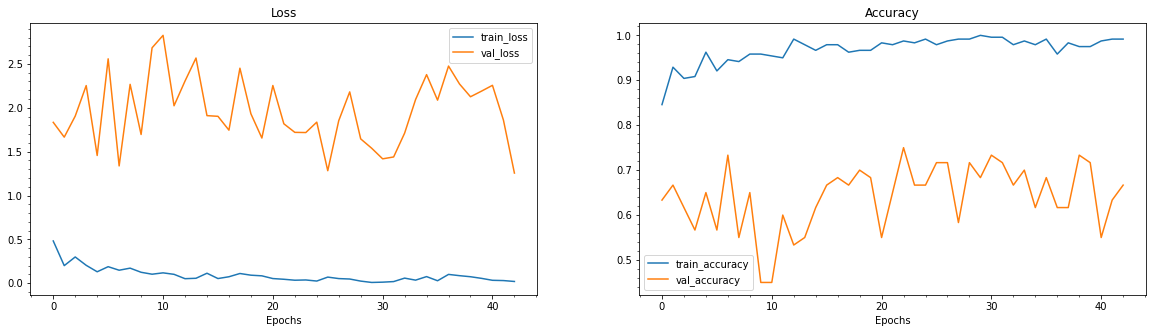

In [ ]:
model, history_finetune1 = fit_model(model, train_batches, val_batches, epochs=100)

---VALIDATION---
loss = 1.9012, accuracy = 71.67%

---TEST---


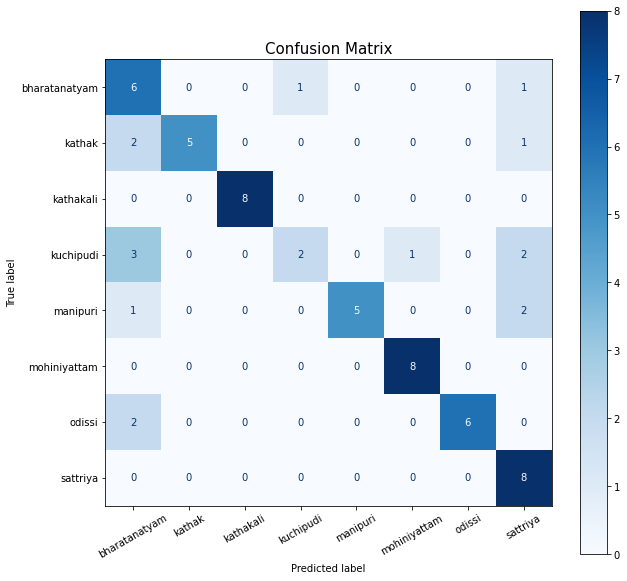


Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.43      0.75      0.55         8
       kathak       1.00      0.62      0.77         8
    kathakali       1.00      1.00      1.00         8
    kuchipudi       0.67      0.25      0.36         8
     manipuri       1.00      0.62      0.77         8
 mohiniyattam       0.89      1.00      0.94         8
       odissi       1.00      0.75      0.86         8
     sattriya       0.57      1.00      0.73         8

     accuracy                           0.75        64
    macro avg       0.82      0.75      0.75        64
 weighted avg       0.82      0.75      0.75        64



In [ ]:
evaluate_model(model, val_batches, test_batches)

## Stage-3: Fine-tuning the entire pretrained base model

In [ ]:
model.layers[0].trainable = True

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                        

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(1e-4), # smaller learning rate
    metrics=["accuracy"]
)

Stopped training after 46 epochs



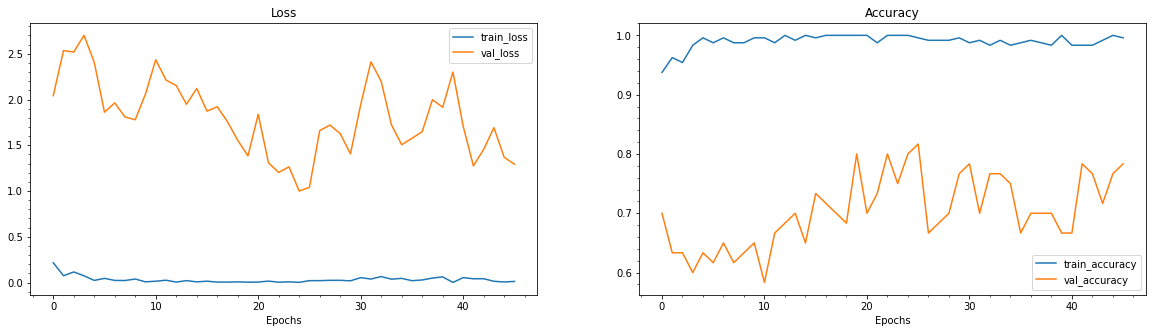

In [ ]:
model, history_finetune2 = fit_model(model, train_batches, val_batches, epochs=100)

---VALIDATION---
loss = 1.2146, accuracy = 76.67%

---TEST---


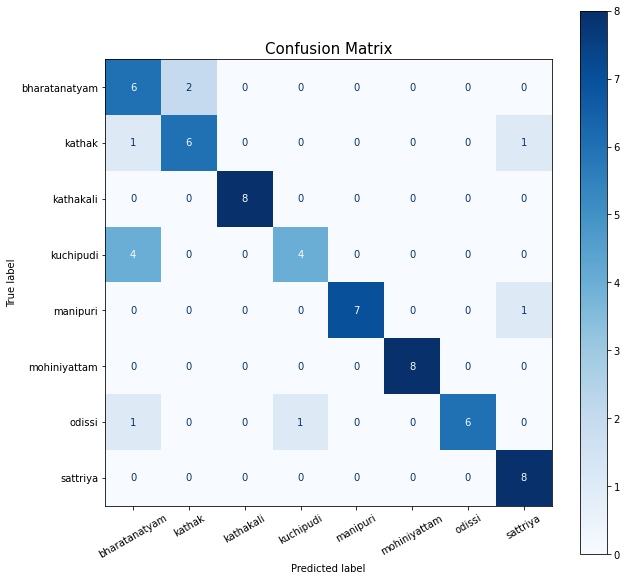


Classification Report:
               precision    recall  f1-score   support

bharatanatyam       0.50      0.75      0.60         8
       kathak       0.75      0.75      0.75         8
    kathakali       1.00      1.00      1.00         8
    kuchipudi       0.80      0.50      0.62         8
     manipuri       1.00      0.88      0.93         8
 mohiniyattam       1.00      1.00      1.00         8
       odissi       1.00      0.75      0.86         8
     sattriya       0.80      1.00      0.89         8

     accuracy                           0.83        64
    macro avg       0.86      0.83      0.83        64
 weighted avg       0.86      0.83      0.83        64



In [ ]:
evaluate_model(model, val_batches, test_batches)

# Summary

* In notebook 02, we tried out 5 pretrained networks for feature extraction, with both ResNet152 and DenseNet201 giving the best performance on the test set. However, DenseNet had a more stable validation-test comparison, so we choose it for the next step of transfer learning - fine-tuning.

* Fine-tuning experiments are divided in three stages: 
    1. Retraining the feature-extraction step (same as notebook 02).
    2. Unfreezing a few layers of the pretrained network and training it with our dataset images.
    3. Unfreezing the entire pretrained network and training it with our images, but with a smaller learning rate to avoid completely overwriting the pretrained weights.

* We were able to make the improvements in accuracy that we expected from the two stages of fine-tuning.
    * Stage 1: Val - 0.62, Test - 0.70
    * Stage 2: Val - 0.72, Test - 0.75
    * Stage 3: Val - 0.77, Test - 0.83

* Across the approaches that we tried in the three notebooks, by adding in data augmentation, feature-extraction transfer learning, and fine-tuning of pretrained networks, **we were able to improve from 41% to 83% in accuracy (more than a 100% increase)**.